# Commands Recognition with TensorFlow

The purpose of this note book is to build a simple acoustic model which can automate voice commands recognition using Tensorflow

In order to use deep learning for speech recognition, we need to convert our soundfiles to numerical respresentations.

Preprocessing procedure:

- convert audio to time series
<img src="imgs/raw_audio_form.png" width="500" height="340"> 

- analyse fourier transform (*optional)

<img src="imgs/fft.png" width="500" height="340"> 

- for speech recognition use short-time fourier transform (stft)

<img src="imgs/spectogram.png" width="500" height="340"> 

- extract Mel-Frequency Cepstrum Cooefficients (feature extractions from stft)


<img src="imgs/mfcc.png" width="500" height="340"> 

The preprocessing workflow is described in the preprocessing_audio_files.ipynb notebook.



In [1]:
from preprocess import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1, L2, l1_l2
import matplotlib.pyplot as plt

%load_ext autoreload

%autoreload 2

2022-05-13 21:27:57.393004: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-13 21:27:57.393098: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Convert raw audio to MFCC arrays for training

In [2]:
max_len = 11
buckets = 20

# Save data to array file first
save_data_to_array(max_len=max_len, n_mfcc=buckets)

Saving vectors of label - 'up': 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2375/2375 [00:14<00:00, 166.55it/s]


## Import Training Data

In [3]:
labels, _, _ = get_labels()
labels

['right', 'down', 'left', 'up']

In [4]:
# Getting first arrays
X = np.load(labels[0] + '.npy')
y = np.zeros(X.shape[0])

# Append all of the dataset into one single array, same goes for y
for i, label in enumerate(labels[1:]):
    x = np.load(label + '.npy')
    X = np.vstack((X, x))
    y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

In [5]:
X.shape[0] == len(y)

True

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [7]:
X_train.shape,  y_train.shape, X_test.shape, y_test.shape

((6617, 20, 11), (6617,), (2837, 20, 11), (2837,))

# Visualize data

In [8]:
# # Feature dimension
channels = 1

# In order plot mffc as an image, we need to reshape the data so we can plot the channel value.
X_train = X_train.reshape(X_train.shape[0], buckets, max_len, channels)
X_test = X_test.reshape(X_test.shape[0], buckets, max_len, channels)

In [9]:
X_train.shape,  y_train.shape, X_test.shape, y_test.shape

((6617, 20, 11, 1), (6617,), (2837, 20, 11, 1), (2837,))

0.0


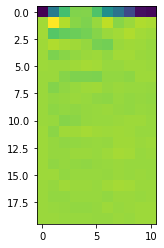

In [10]:
plt.imshow(X_train[100, :, :, 0])
print(y_train[100])

# Model Training

## ANN model 

In [11]:
# one hot encode our targets for multiclass classification
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [12]:
# reshape the data back to one MFCC array per observation
X_train = X_train.reshape(X_train.shape[0], buckets, max_len)
X_test = X_test.reshape(X_test.shape[0], buckets, max_len)

In [13]:
X_train.shape,  y_train.shape, X_test.shape, y_test.shape

((6617, 20, 11), (6617,), (2837, 20, 11), (2837,))

In [14]:
epochs = 500
batch_size = 32
num_classes = 4

# Build model
model = Sequential()
model.add(Flatten(input_shape=(buckets, max_len)))
model.add(Dense(25,activation='relu',activity_regularizer=L2(0.0001)))
model.add(Dense(10,activation='relu', activity_regularizer=L2(0.0001)))
model.add(Dense(num_classes, activation='softmax'))

2022-05-13 21:28:56.193693: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-13 21:28:56.193798: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-13 21:28:56.193834: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-3L661AJ): /proc/driver/nvidia/version does not exist
2022-05-13 21:28:56.194415: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# Compile model
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 220)               0         
                                                                 
 dense (Dense)               (None, 25)                5525      
                                                                 
 dense_1 (Dense)             (None, 10)                260       
                                                                 
 dense_2 (Dense)             (None, 4)                 44        
                                                                 
Total params: 5,829
Trainable params: 5,829
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Train our model
es = EarlyStopping(patience=30, restore_best_weights=True)

history = model.fit(X_train, y_train_hot, 
                    validation_split=0.3, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    callbacks=[es])

Epoch 1/500
145/145 [==============================] - 1s 3ms/step - loss: 18.8981 - accuracy: 0.3025 - val_loss: 3.6584 - val_accuracy: 0.3379
Epoch 2/500
145/145 [==============================] - 0s 2ms/step - loss: 2.6005 - accuracy: 0.3405 - val_loss: 1.8963 - val_accuracy: 0.3479
Epoch 3/500
145/145 [==============================] - 0s 2ms/step - loss: 1.6703 - accuracy: 0.3524 - val_loss: 1.5809 - val_accuracy: 0.3474
Epoch 4/500
145/145 [==============================] - 0s 2ms/step - loss: 1.4584 - accuracy: 0.3757 - val_loss: 1.4579 - val_accuracy: 0.3499
Epoch 5/500
145/145 [==============================] - 0s 2ms/step - loss: 1.3634 - accuracy: 0.3798 - val_loss: 1.3982 - val_accuracy: 0.3651
Epoch 6/500
145/145 [==============================] - 0s 2ms/step - loss: 1.2986 - accuracy: 0.4047 - val_loss: 1.3781 - val_accuracy: 0.3711
Epoch 7/500
145/145 [==============================] - 0s 2ms/step - loss: 1.2565 - accuracy: 0.4291 - val_loss: 1.3486 - val_accuracy: 0.391

Epoch 58/500
145/145 [==============================] - 0s 2ms/step - loss: 0.5395 - accuracy: 0.8219 - val_loss: 0.9646 - val_accuracy: 0.7170
Epoch 59/500
145/145 [==============================] - 0s 2ms/step - loss: 0.5392 - accuracy: 0.8234 - val_loss: 0.9201 - val_accuracy: 0.7165
Epoch 60/500
145/145 [==============================] - 0s 2ms/step - loss: 0.5430 - accuracy: 0.8251 - val_loss: 0.8886 - val_accuracy: 0.7457
Epoch 61/500
145/145 [==============================] - 0s 2ms/step - loss: 0.5320 - accuracy: 0.8290 - val_loss: 0.9128 - val_accuracy: 0.7261
Epoch 62/500
145/145 [==============================] - 0s 2ms/step - loss: 0.5364 - accuracy: 0.8303 - val_loss: 0.9245 - val_accuracy: 0.7316
Epoch 63/500
145/145 [==============================] - 0s 2ms/step - loss: 0.5157 - accuracy: 0.8348 - val_loss: 0.9224 - val_accuracy: 0.7387
Epoch 64/500
145/145 [==============================] - 0s 2ms/step - loss: 0.5173 - accuracy: 0.8350 - val_loss: 1.0540 - val_accuracy:

In [18]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.title('Train loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

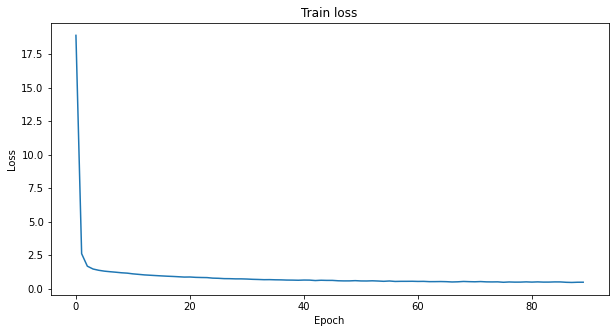

In [19]:
plot_history(history)

In [20]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

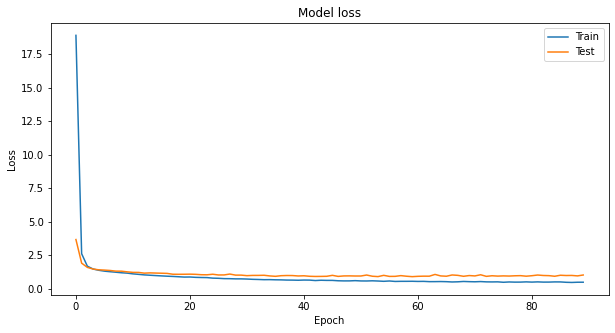

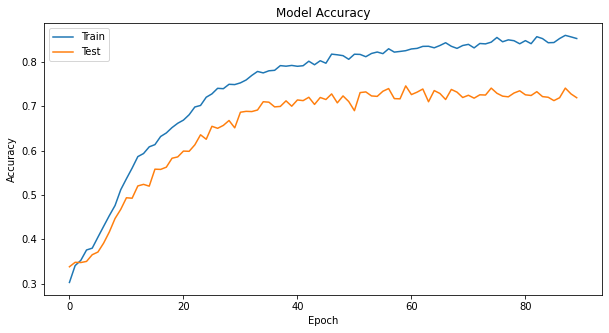

In [21]:
plot_loss_accuracy(history)

## CNN Model

In [22]:
# expand dimensions, so that the last dimension is the number of channels.
# this is required for CNN.
X_train = X_train.reshape(X_train.shape[0], buckets, max_len, channels)
X_test = X_test.reshape(X_test.shape[0], buckets, max_len, channels)

In [23]:
X_train.shape,  y_train.shape, X_test.shape, y_test.shape

((6617, 20, 11, 1), (6617,), (2837, 20, 11, 1), (2837,))

### CNN with 1 CONV2D layer, 1 Maxpool layer

In [24]:
# build model
CNN_model_1 = Sequential()
CNN_model_1.add(Conv2D(32,
    (3,3),
    input_shape=(buckets,max_len,channels),
    activation='relu'))
CNN_model_1.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model_1.add(Flatten())
CNN_model_1.add(Dense(128, activation='relu'))
CNN_model_1.add(Dense(num_classes, activation='softmax'))

#Compile
CNN_model_1.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])



In [25]:
CNN_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 9, 32)         320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 4, 32)         0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               147584    
                                                                 
 dense_4 (Dense)             (None, 4)                 516       
                                                                 
Total params: 148,420
Trainable params: 148,420
Non-trainable params: 0
________________________________________________

In [26]:
# Train our model
es = EarlyStopping(patience=30, restore_best_weights=True)

CNN_model_1_history = CNN_model_1.fit(X_train, y_train_hot, 
                    validation_split=0.3, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    callbacks=[es])

Epoch 1/500
145/145 [==============================] - 1s 6ms/step - loss: 2.5747 - accuracy: 0.5247 - val_loss: 1.0624 - val_accuracy: 0.6475
Epoch 2/500
145/145 [==============================] - 1s 5ms/step - loss: 0.7422 - accuracy: 0.7340 - val_loss: 0.6373 - val_accuracy: 0.7805
Epoch 3/500
145/145 [==============================] - 1s 5ms/step - loss: 0.5405 - accuracy: 0.8031 - val_loss: 0.5522 - val_accuracy: 0.7956
Epoch 4/500
145/145 [==============================] - 1s 5ms/step - loss: 0.4024 - accuracy: 0.8583 - val_loss: 0.4794 - val_accuracy: 0.8218
Epoch 5/500
145/145 [==============================] - 1s 4ms/step - loss: 0.3453 - accuracy: 0.8758 - val_loss: 0.5005 - val_accuracy: 0.8253
Epoch 6/500
145/145 [==============================] - 1s 4ms/step - loss: 0.3281 - accuracy: 0.8845 - val_loss: 0.4549 - val_accuracy: 0.8343
Epoch 7/500
145/145 [==============================] - 1s 4ms/step - loss: 0.2742 - accuracy: 0.9017 - val_loss: 0.4850 - val_accuracy: 0.8348

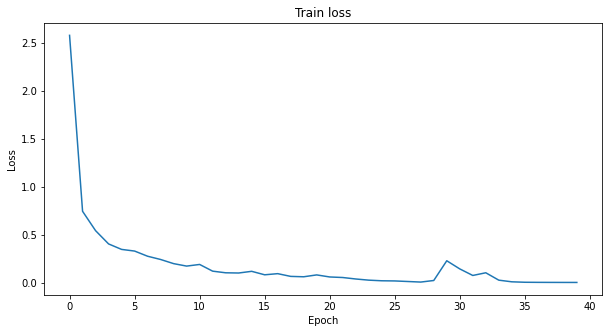

In [27]:
plot_history(CNN_model_1_history)

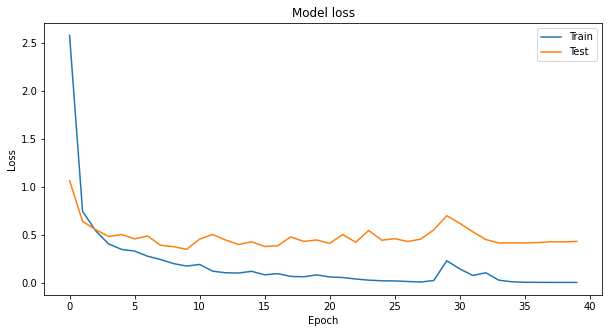

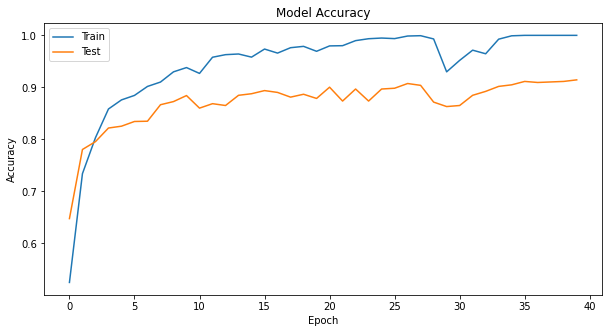

In [28]:
plot_loss_accuracy(CNN_model_1_history)

### CNN with 2 CONV2D layers, 2 Maxpool layers


In [29]:
# build model
CNN_model_2 = Sequential()
CNN_model_2.add(Conv2D(32,
    (3,3),
    input_shape=(buckets,max_len,channels),
    activation='relu'))
CNN_model_2.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model_2.add(Conv2D(32,
    (3,3),
    input_shape=(buckets,max_len,channels),
    activation='relu'))
CNN_model_2.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model_2.add(Flatten())
CNN_model_2.add(Dense(128, activation='relu'))
CNN_model_2.add(Dense(num_classes, activation='softmax'))

#Compile
CNN_model_2.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])


In [30]:
CNN_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 18, 9, 32)         320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 4, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 2, 32)          9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 1, 32)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 96)                0         
                                                                 
 dense_5 (Dense)             (None, 128)              

In [31]:
# Train our model
es = EarlyStopping(patience=30, restore_best_weights=True)

CNN_model_2_history = CNN_model_2.fit(X_train, y_train_hot, 
                    validation_split=0.3, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    callbacks=[es])

Epoch 1/500
145/145 [==============================] - 2s 10ms/step - loss: 1.1897 - accuracy: 0.5807 - val_loss: 0.7580 - val_accuracy: 0.7024
Epoch 2/500
145/145 [==============================] - 1s 7ms/step - loss: 0.5769 - accuracy: 0.7765 - val_loss: 0.6627 - val_accuracy: 0.7553
Epoch 3/500
145/145 [==============================] - 1s 9ms/step - loss: 0.4347 - accuracy: 0.8402 - val_loss: 0.4731 - val_accuracy: 0.8303
Epoch 4/500
145/145 [==============================] - 1s 4ms/step - loss: 0.3430 - accuracy: 0.8685 - val_loss: 0.4239 - val_accuracy: 0.8479
Epoch 5/500
145/145 [==============================] - 1s 4ms/step - loss: 0.3014 - accuracy: 0.8881 - val_loss: 0.4051 - val_accuracy: 0.8545
Epoch 6/500
145/145 [==============================] - 1s 5ms/step - loss: 0.2528 - accuracy: 0.9052 - val_loss: 0.4390 - val_accuracy: 0.8560
Epoch 7/500
145/145 [==============================] - 1s 4ms/step - loss: 0.2363 - accuracy: 0.9138 - val_loss: 0.4009 - val_accuracy: 0.855

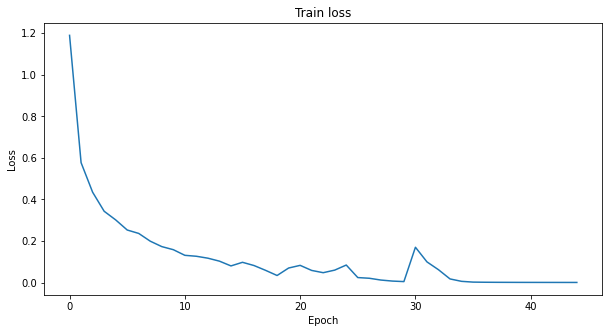

In [32]:
plot_history(CNN_model_2_history)

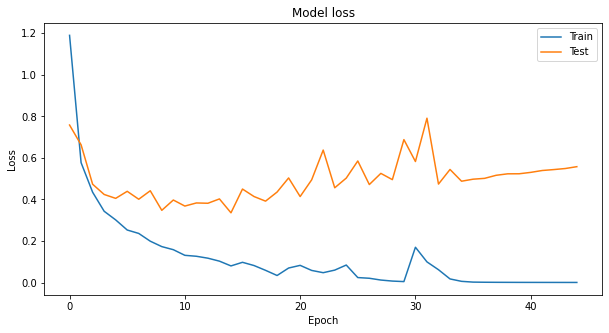

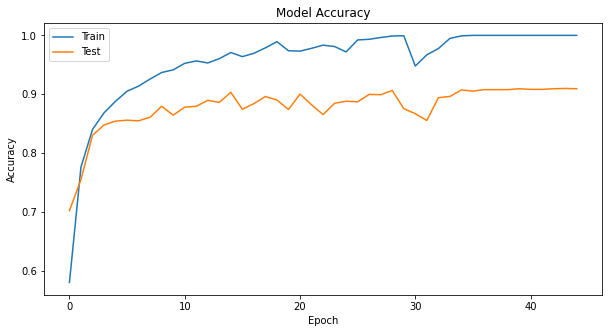

In [33]:
plot_loss_accuracy(CNN_model_2_history)

### CNN with 2 CONV2D layers, 2 Maxpool layers, 2 Dropout Layers

Both the 1 and 2 CONV2D layer models exhibit over-fitting. applying dropout layers to reduce variance

In [34]:
# build model
CNN_model_3 = Sequential()
CNN_model_3.add(Conv2D(32,
    (3,3),
    input_shape=(buckets,max_len,channels),
    activation='relu'))
CNN_model_3.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model_3.add(Dropout(0.25))
CNN_model_3.add(Conv2D(32,
    (3,3),
    input_shape=(buckets,max_len,channels),
    activation='relu'))
CNN_model_3.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model_3.add(Dropout(0.25))
CNN_model_3.add(Flatten())
CNN_model_3.add(Dense(128, activation='relu'))
CNN_model_3.add(Dense(num_classes, activation='softmax'))

#Compile
CNN_model_3.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])

In [35]:
CNN_model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 18, 9, 32)         320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 9, 4, 32)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 9, 4, 32)          0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 2, 32)          9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3, 1, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 3, 1, 32)         

In [36]:
# Train our model
es = EarlyStopping(patience=30, restore_best_weights=True)

CNN_model_3_history = CNN_model_3.fit(X_train, y_train_hot, 
                    validation_split=0.3, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    callbacks=[es])

Epoch 1/500
145/145 [==============================] - 2s 8ms/step - loss: 2.3475 - accuracy: 0.2939 - val_loss: 1.3637 - val_accuracy: 0.3147
Epoch 2/500
145/145 [==============================] - 1s 6ms/step - loss: 1.3398 - accuracy: 0.3535 - val_loss: 1.2916 - val_accuracy: 0.4220
Epoch 3/500
145/145 [==============================] - 1s 6ms/step - loss: 1.2702 - accuracy: 0.4135 - val_loss: 1.1596 - val_accuracy: 0.5222
Epoch 4/500
145/145 [==============================] - 1s 6ms/step - loss: 1.1807 - accuracy: 0.4783 - val_loss: 1.0171 - val_accuracy: 0.5962
Epoch 5/500
145/145 [==============================] - 1s 6ms/step - loss: 1.0826 - accuracy: 0.5416 - val_loss: 0.9526 - val_accuracy: 0.6284
Epoch 6/500
145/145 [==============================] - 1s 5ms/step - loss: 1.0227 - accuracy: 0.5757 - val_loss: 0.8374 - val_accuracy: 0.7100
Epoch 7/500
145/145 [==============================] - 1s 6ms/step - loss: 0.9545 - accuracy: 0.6076 - val_loss: 0.7110 - val_accuracy: 0.7508

Epoch 58/500
145/145 [==============================] - 1s 7ms/step - loss: 0.3581 - accuracy: 0.8650 - val_loss: 0.3220 - val_accuracy: 0.8887
Epoch 59/500
145/145 [==============================] - 1s 7ms/step - loss: 0.3571 - accuracy: 0.8646 - val_loss: 0.3073 - val_accuracy: 0.8983
Epoch 60/500
145/145 [==============================] - 1s 8ms/step - loss: 0.3486 - accuracy: 0.8678 - val_loss: 0.2929 - val_accuracy: 0.8968
Epoch 61/500
145/145 [==============================] - 2s 11ms/step - loss: 0.3430 - accuracy: 0.8726 - val_loss: 0.3189 - val_accuracy: 0.8877
Epoch 62/500
145/145 [==============================] - 2s 11ms/step - loss: 0.3490 - accuracy: 0.8696 - val_loss: 0.3002 - val_accuracy: 0.8912
Epoch 63/500
145/145 [==============================] - 1s 10ms/step - loss: 0.3432 - accuracy: 0.8659 - val_loss: 0.2969 - val_accuracy: 0.8907
Epoch 64/500
145/145 [==============================] - 1s 10ms/step - loss: 0.3440 - accuracy: 0.8715 - val_loss: 0.2902 - val_accur

Epoch 115/500
145/145 [==============================] - 1s 5ms/step - loss: 0.2414 - accuracy: 0.9102 - val_loss: 0.2760 - val_accuracy: 0.9008
Epoch 116/500
145/145 [==============================] - 1s 5ms/step - loss: 0.2296 - accuracy: 0.9169 - val_loss: 0.2920 - val_accuracy: 0.8943
Epoch 117/500
145/145 [==============================] - 1s 5ms/step - loss: 0.2488 - accuracy: 0.9115 - val_loss: 0.2800 - val_accuracy: 0.9063
Epoch 118/500
145/145 [==============================] - 1s 5ms/step - loss: 0.2320 - accuracy: 0.9121 - val_loss: 0.2742 - val_accuracy: 0.9099
Epoch 119/500
145/145 [==============================] - 1s 5ms/step - loss: 0.2467 - accuracy: 0.9100 - val_loss: 0.2687 - val_accuracy: 0.9053
Epoch 120/500
145/145 [==============================] - 1s 5ms/step - loss: 0.2407 - accuracy: 0.9136 - val_loss: 0.2783 - val_accuracy: 0.9053
Epoch 121/500
145/145 [==============================] - 1s 5ms/step - loss: 0.2597 - accuracy: 0.9059 - val_loss: 0.2774 - val_ac

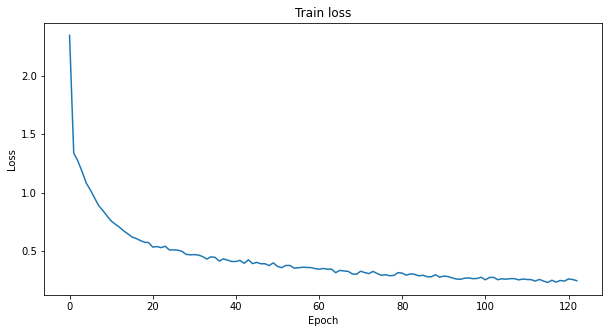

In [37]:
plot_history(CNN_model_3_history)

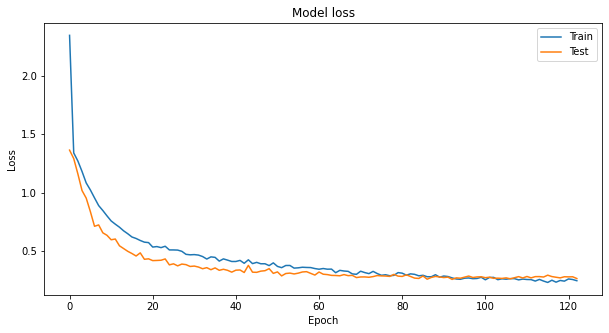

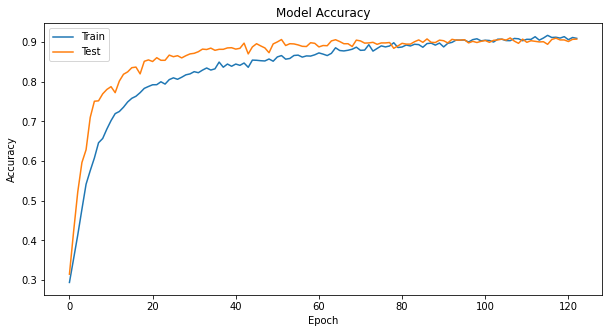

In [38]:
plot_loss_accuracy(CNN_model_3_history)

### Cross Validation

In [39]:
def initialize_model():
    CNN_model_3 = Sequential()
    CNN_model_3.add(Conv2D(32,
        (3,3),
        input_shape=(buckets,max_len,channels),
        activation='relu'))
    CNN_model_3.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model_3.add(Dropout(0.25))
    CNN_model_3.add(Conv2D(32,
        (3,3),
        input_shape=(buckets,max_len,channels),
        activation='relu'))
    CNN_model_3.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model_3.add(Dropout(0.25))
    CNN_model_3.add(Flatten())
    CNN_model_3.add(Dense(128, activation='relu'))
    CNN_model_3.add(Dense(num_classes, activation='softmax'))

    #Compile
    CNN_model_3.compile(loss='categorical_crossentropy', optimizer='adam',
                    metrics=['accuracy'])
    
    return CNN_model_3

In [40]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
kf.get_n_splits()

epochs = 500
batch_size = 32
num_classes = 4
es = EarlyStopping(patience=30, restore_best_weights=True, monitor='accuracy')

results = []

for train_index, val_index in kf.split(X_train):
    
    # Split the data into train and test
    X_train2, X_val = X_train[train_index], X_train[val_index]
    y_train_hot2, y_val_hot = y_train_hot[train_index], y_train_hot[val_index]
      
    # Initialize the model
    model = initialize_model()
    
    # Fit the model on the train data
    model.fit(X_train2, 
              y_train_hot2,
              epochs = epochs,
              batch_size = batch_size,
              callbacks=[es],
              verbose = 0)
    
    # Evaluate the model on the test data
    res = model.evaluate(X_val, y_val_hot, verbose=0)
    results.append(res)

In [41]:
results

[[0.20947641134262085, 0.9222054481506348],
 [0.2115858793258667, 0.9320241808891296],
 [0.2356494963169098, 0.9168556332588196],
 [0.25055834650993347, 0.9092970490455627],
 [0.19255687296390533, 0.9274376630783081]]

In [42]:
accuracy = [_[1] for _ in results]

print(f'Mean accuracy : {np.mean(accuracy)*100:.2f}% (±{np.std(accuracy)*100:.2f})')

Mean accuracy : 92.16% (±0.80)


# Model Evaluation